In [2]:
import numpy as np
import astropy.io.fits as fitsio
import matplotlib.pyplot as plt 
from astropy.table import Table
%matplotlib inline

In [21]:
def random_patch(n_dens=2500, plate_radius=1.65):
    """Generates random set of points within a single plate.
    n_dens: number density of the random points to be generated
    plate_radius: radius of DESI plate in degrees.
    """
    n_total = int(4.0* n_dens * plate_radius**2)
    
    #The points are generated on a "square" centered around theta=pi/2 and phi=pi (spherical coordinates)
    phi = 2.0*(np.random.random(n_total) - 0.5) * np.deg2rad(plate_radius)
    costheta = 2.0*(np.random.random(n_total)-0.5) * np.deg2rad(plate_radius)
    theta = np.arccos(costheta) 
    
    #We now select the points inside the circle
    mu = np.cos(phi) * np.sin(theta) # dot product between each point and unit vector along x
    inside = np.abs(mu) > np.cos(np.deg2rad(plate_radius)) 
    return {'RA':np.rad2deg(np.pi - phi[inside]), 'DEC':np.rad2deg(theta[inside]-np.pi/2.0)}

def fill_columns(input_dict):
    column_vals = {'DESI_TARGET':1,
               'MWS_TARGET':0,
               'BGS_TARGET':0, 
               'OBSCONDITIONS':1, 
               'BRICKNAME':'180d000',
               'SUBPRIORITY':0,
               'NUMOBSMORE':1,
               'PRIORITY':1}
    
    n_points = len(input_dict['RA'])
    for k in column_vals.keys():
        if k not in input_dict.keys():
            if k=='SUBPRIORITY':
                input_dict[k] = np.random.random(n_points)
            else:
                input_dict[k] = np.repeat(column_vals[k], n_points)
    return input_dict

def write_targets(n_target_dens=800, n_sky_dens=1200, n_star_dens=120):
    target_points = random_patch(n_dens=n_target_dens)
    sky_points = random_patch(n_dens=n_sky_dens)
    star_points = random_patch(n_dens=n_star_dens)

    n_target = len(target_points['RA'])
    n_sky = len(sky_points['RA'])
    n_star = len(star_points['RA'])
    n_tot = n_target +n_sky + n_star
    id_list = np.arange(n_tot)
    target_points['TARGETID'] = id_list[:n_target]
    sky_points['TARGETID'] = id_list[n_target:n_target+n_sky]
    star_points['TARGETID'] = id_list[-n_star:]

    target_points = fill_columns(target_points)
    sky_points = fill_columns(sky_points)
    star_points = fill_columns(star_points)
    Table(target_points).write('targets.fits', overwrite=True)
    Table(sky_points).write('sky.fits', overwrite=True)
    Table(star_points).write('star.fits', overwrite=True)
    
def write_tile(ra=180.0, dec=0.0):
    tile = {'TILEID':[0], 
            'RA':[ra,
            'DEC':dec,
            'PASS':1,
            'IN_DESI':1,
            'EBV_MED':0.0,
            'AIRMASS':1.0,
            'STAR_DENSITY':1.0,
            'EXPOSEFAC':1.0,
            'PROGRAM':'DARK',
            'OBSCONDITIONS':1}
    Table(tile).write('tile.fits')

In [20]:
write_targets()
write_tile()

ValueError: Elements in list initialization must be either Column or list-like

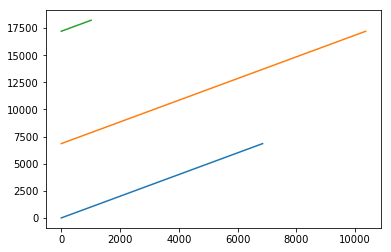

In [17]:
targets = Table.read('targets.fits')
sky = Table.read('sky.fits')
star = Table.read('star.fits')
plt.plot(targets['TARGETID'])
plt.plot(sky['TARGETID'])
plt.plot(star['TARGETID'])


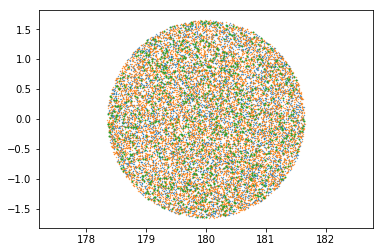

In [18]:
plt.scatter(targets['RA'], targets['DEC'], s=0.1)
plt.scatter(sky['RA'], sky['DEC'], s=0.1)
plt.scatter(star['RA'], star['DEC'], s=1)
a = plt.axis('equal')